In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stage2_test_variants.csv', 'test_text', 'stage1_solution_filtered.csv', 'training_variants', 'training_text', 'stage2_sample_submission.csv', 'stage2_test_text.csv', 'test_variants', 'submissionFile']


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk
from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
df_train_var =pd.read_csv("../input/training_variants")
# data.columns
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df_train_text = pd.read_csv("../input/training_text", sep = "\|\|", engine = "python", names = ["ID", "TEXT"], skiprows =1)
df_train_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
# stop_words = set(stopwords.words('english'))

In [6]:
def nltk_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
# replacing special characters
        total_text = re.sub('[^a-zA-Z0-9/n]',' ',total_text)
#         replacing multi space with one
        total_text = re,sub('s+',' ', total_text)
        total_text = total_text.lower
        #remove stop words
        for word in total_text.split():
            if word not in stop_words:
                string +=word+" "
        df_train_text[column][index] = total_text

In [7]:
df_train  = pd.merge(df_train_var, df_train_text, on = "ID", how = "left")
df_train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
df_test_var =pd.read_csv("../input/test_variants")
# data.columns
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [9]:
df_test_text = pd.read_csv("../input/test_text", sep = "\|\|", engine = "python",names = ["ID", "TEXT"], skiprows =1)
df_test_text.head()

,ID,TEXT
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [10]:
df_test = pd.merge(df_test_var, df_test_text, how = "left", on = "ID" )
df_test.head(3)

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...


In [11]:
df_train.describe(include = "all")

,ID,Gene,Variation,Class,TEXT
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


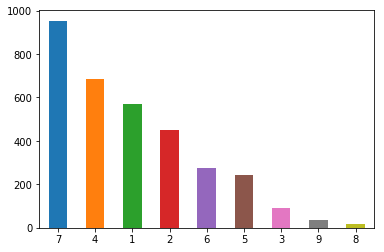

In [12]:
df_train.Class.value_counts().plot(kind = 'bar', rot = 0)

In [13]:
df_train,_ = train_test_split (df_train, test_size = 0.7, random_state = 8, stratify = df_train['Class'])
df_train.shape

(996, 5)

In [14]:
def evaluate_features(X, y, clf = None):
    if clf == None:
        clf = LogisticRegression()
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), n_jobs = -1,method = 'predict_proba',verbose =2)
    pred_indices = np.argmax(probas, axis =1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss :{}'.format(log_loss(y,probas)))
    print('Accuracy:{}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y,preds)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :0.34456225154049025
Accuracy:0.9466666666666667


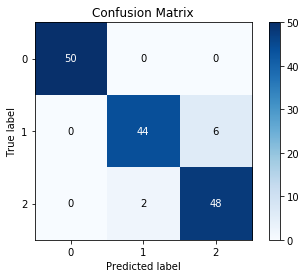

In [15]:
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

In [16]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer = 'word',tokenizer = nltk.word_tokenize, preprocessor =None, stop_words ='english',max_features = None)
bag_of_words = count_vectorizer.fit_transform(df_train['TEXT'])

In [18]:
len(count_vectorizer.get_feature_names())

157768

In [19]:
svd = TruncatedSVD(n_components = 25, n_iter = 25, random_state = 12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.6559847546464688
Accuracy:0.4819277108433735


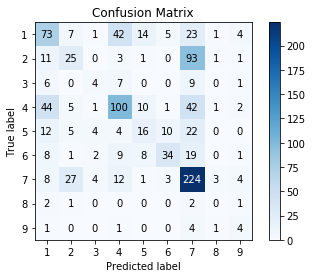

In [20]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.4401389762830952
Accuracy:0.5100401606425703


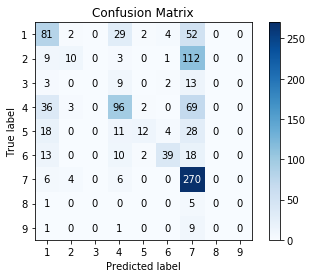

In [21]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    
tfidf = count_vectorizer.fit_transform(df_train['TEXT'])
len(count_vectorizer.get_feature_names())

157768

In [24]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.5090307759705
Accuracy:0.463855421686747


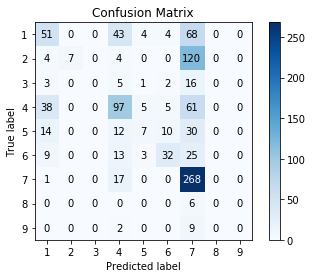

In [25]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.3536912155515521
Accuracy:0.5110441767068273


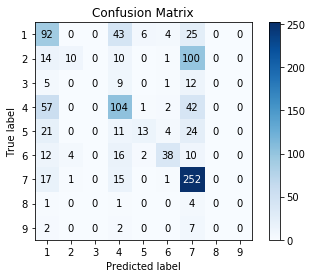

In [26]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel(), RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1) )

In [27]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)
def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [28]:
w2vec = get_word2vec(
    MySentences(
        df_train['TEXT'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [29]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [30]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['TEXT'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


In [31]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['TEXT'].values)

In [32]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train['TEXT'].values)
X = pad_sequences(X, maxlen=2000)

In [33]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(796, 2000) (796, 9)
(200, 2000) (200, 9)


In [35]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 636 samples, validate on 160 samples
Epoch 1/8
636/636 [==============================] - 76s 120ms/step - loss: 2.0276 - categorical_crossentropy: 2.0276 - val_loss: 1.9065 - val_categorical_crossentropy: 1.9065

Epoch 00001: val_loss improved from inf to 1.90650, saving model to keras_model
Epoch 2/8
636/636 [==============================] - 73s 115ms/step - loss: 1.8703 - categorical_crossentropy: 1.8703 - val_loss: 1.8444 - val_categorical_crossentropy: 1.8444

Epoch 00002: val_loss improved from 1.90650 to 1.84441, saving model to keras_model
Epoch 3/8
636/636 [==============================] - 73s 115ms/step - loss: 1.7822 - categorical_crossentropy: 1.7822 - val_loss: 1.7788 - val_categorical_crossentropy: 1.7788

Epoch 00003: val_loss improved from 1.84441 to 1.77885, saving model to keras_model
Epoch 4/8
636/636 [==============================] - 73s 115ms/step - loss: 1.6264 - categorical_crossentropy: 1.6264 - val_loss: 1.7028 - val_categorical_crossentropy: 1.7028

In [36]:
model = load_model('keras_model')

In [37]:
probas = model.predict(X_test)

Log loss: 1.4212432263046504
Accuracy: 0.48


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


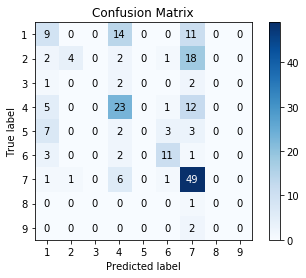

In [38]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

In [39]:
gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(df_train['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)

In [40]:
variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform(df_train['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.5031979443633878
Accuracy:0.44779116465863456


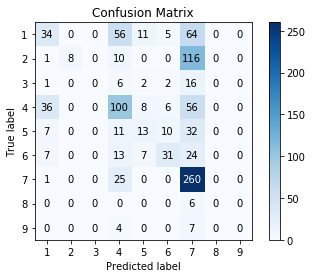

In [41]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'])

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.3387910362485855
Accuracy:0.5230923694779116


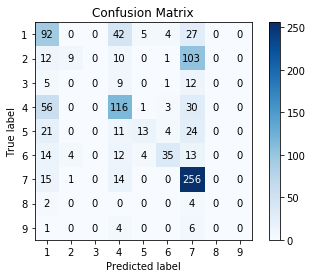

In [42]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.3165172249711679
Accuracy:0.5261044176706827


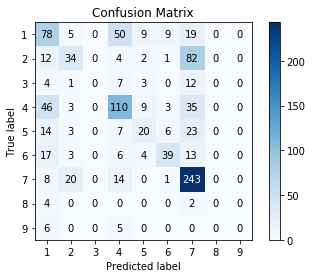

In [43]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'])

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.317120400667931
Accuracy:0.5261044176706827


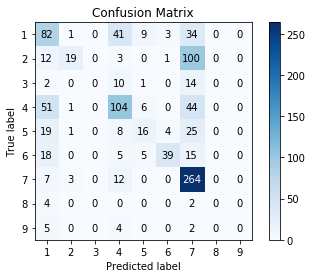

In [44]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [45]:
one_hot_gene = pd.get_dummies(df_train['Gene'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

In [46]:
one_hot_variation = pd.get_dummies(df_train['Variation'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss :1.3679867789668085
Accuracy:0.5060240963855421


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


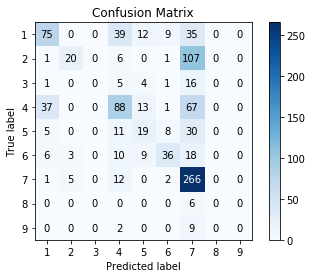

In [47]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train['Class'])

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Log loss :1.238809273510188
Accuracy:0.5421686746987951


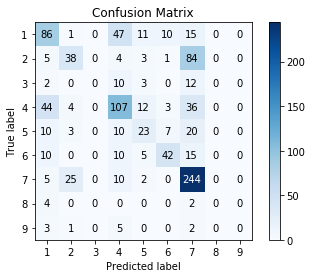

In [48]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, mean_embedded)), df_train['Class'])

In [49]:
lr_w2vec = LogisticRegression()
lr_w2vec.fit(mean_embedded, df_train['Class'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
df_test['TEXT'].isnull().sum()

1

In [51]:
df_test['TEXT'].fillna(' ', inplace = True)

In [52]:
mean_embedded_test = mean_embedding_vectorizer.transform(df_test['TEXT'])

In [53]:
probas = lr_w2vec.predict_proba(mean_embedded_test)

In [54]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.026775,0.256810,0.023152,0.024303,0.023414,0.049353,0.584300,0.006713,0.005182,0
1,0.199250,0.114170,0.018904,0.387076,0.020024,0.045483,0.182779,0.010490,0.021824,1
2,0.078785,0.160761,0.011093,0.076588,0.016954,0.053931,0.579324,0.008996,0.013568,2
3,0.043902,0.196709,0.007453,0.080031,0.035150,0.021945,0.592177,0.011480,0.011153,3
4,0.163774,0.195789,0.015022,0.247416,0.013251,0.038809,0.305888,0.006410,0.013642,4


In [55]:
submission_df.to_csv('submission.csv', index=False)

In [56]:
xgb_w2vec = XGBClassifier(max_depth=4,
                          objective='multi:softprob',
                          learning_rate=0.03333)
xgb_w2vec.fit(mean_embedded, df_train['Class'])
probas = xgb_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

In [57]:
svc_w2vec = SVC(kernel='linear', probability=True)
svc_w2vec.fit(mean_embedded, df_train['Class'])
probas = svc_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

In [58]:
Xtest = tokenizer.texts_to_sequences(df_test['TEXT'].values)
Xtest = pad_sequences(Xtest, maxlen=2000)

In [59]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.018544,0.253460,0.020407,0.017511,0.033609,0.045503,0.603377,0.005979,0.001610,0
1,0.258900,0.135153,0.021779,0.376844,0.024506,0.037595,0.124493,0.006032,0.014697,1
2,0.073249,0.178883,0.018125,0.076405,0.024096,0.042488,0.574852,0.005795,0.006106,2
3,0.022670,0.197276,0.010682,0.044271,0.044785,0.017847,0.651882,0.006020,0.004566,3
4,0.155816,0.204395,0.020411,0.223237,0.020150,0.033149,0.330443,0.004822,0.007577,4


In [60]:
submission_df.to_csv('submission.csv', index=False)